# Environment

## Import packages

In [ ]:
import os, tempfile
# Set wandb directories BEFORE importing wandb
os.environ["WANDB_DIR"] = "D:/peak2vec/wandb"  # Change to drive with more space
os.environ["WANDB_CACHE_DIR"] = "D:/peak2vec/wandb_cache"
os.environ["WANDB_DATA_DIR"] = "D:/peak2vec/wandb_data"
os.environ["TMP"] = "D:/peak2vec/temp"
os.environ["TEMP"] = "D:/peak2vec/temp"

tempfile.tempdir = os.environ["TEMP"]

In [2]:
import time
import wandb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import scanpy as sc
from src.peak2vec import PeakDataset, peak2vec_collate, prepare_adata, get_sampling_distributions

## Global variables

In [3]:
wandb.Table.MAX_ARTIFACT_ROWS = 300_000

## Helper functions

In [4]:
def balanced_downsample(
    df: pd.DataFrame,
    col: str,
    n_per_class: int,
    random_state: int = 0,
    shuffle: bool = True,
) -> pd.DataFrame:
    g = df.groupby(col, group_keys=False, observed=True)

    # sample up to n_per_class per group (no replacement)
    out = g.apply(lambda x: x.sample(n=min(len(x), n_per_class), random_state=random_state), include_groups=True)

    if shuffle:
        out = out.sample(frac=1, random_state=random_state)

    return out.reset_index(drop=True)

## Load data

In [5]:
adata = sc.read_h5ad("data/pbmc10k_atac_filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 10006 × 260822
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'binary'

In [6]:
prepare_adata(adata)
adata

AnnData object with n_obs × n_vars = 10006 × 260822
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Center'
    layers: 'binary'

# Train

## Model

In [7]:
class Peak2Vec(nn.Module):
    """Skip-gram model over peaks with negative sampling."""
    def __init__(self, n_peaks, embedding_dim=64, pos_weight=1.0, sparse=True):
        super(Peak2Vec, self).__init__()
        self.dim = embedding_dim
        self.pos_weight = pos_weight
        self.embedding = nn.Embedding(n_peaks, embedding_dim, sparse=sparse)
        self.reset_params()
    
    def reset_params(self):
        nn.init.uniform_(self.embedding.weight, -0.5 / self.dim, 0.5 / self.dim)

    def forward(self, peaks, peak_pairs, negatives):
        """
        Compute the Skip-gram with Negative Sampling loss.
        peaks: (B,) LongTensor of peak indices
        peak_pairs: (B,) LongTensor of positive context peak indices
        negatives: (B, K) LongTensor of negative sample peak indices
        """
        # Embeddings
        peak_emb = self.embedding(peaks)               # (B, D)
        pair_emb = self.embedding(peak_pairs)          # (B, D)
        neg_emb = self.embedding(negatives)            # (B, K, D)

        # Compute similarity scores
        pos_score = torch.sum(peak_emb * pair_emb, dim=1)                   # (B)
        neg_score = torch.bmm(neg_emb, peak_emb.unsqueeze(2)).squeeze(2)    # (B, K)

        # Loss
        poss_loss = F.softplus(-pos_score)         # -log(sigmoid(x)) = softplus(-x)
        neg_loss = F.softplus(neg_score).sum(1)      # -log(1 - sigmoid(x)) = softplus(x)
        loss = (self.pos_weight * poss_loss + neg_loss).mean()

        with torch.no_grad():
            stats = {
                "pos_score_mean": pos_score.mean().detach(),
                "neg_score_mean": neg_score.mean().detach(),
                "pos_loss_mean":  poss_loss.mean().detach(),
                "neg_loss_mean":  neg_loss.mean().detach(),
            }
        return loss, stats
    
    @torch.no_grad()
    def get_peak_embeddings(self, normalize=True):
        embeddings = self.embedding.weight.detach().cpu()
        if normalize:
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings
    
    @torch.no_grad()
    def most_similar(self, peak_idx, topk=10):
        embeddings = self.get_peak_embeddings(normalize=True)  # (N, D)
        peak_emb = embeddings[peak_idx:peak_idx+1]             # (1, D)
        similarities = (embeddings @ peak_emb.t()).squeeze(1)  # (N)
        values, indices = torch.topk(similarities, topk + 1, embeddings.size(0), largest=True)
        # drop self if in topk
        if indices and indices[0] == peak_idx:
            indices, values = indices[1:], values[1:]
        return indices[:topk], values[:topk]

## Training

In [8]:
seed = 4
n_pairs = 20
n_negative = 20
samples_per_epoch = 20000
batch_size = 512
embedding_dim = 128
trans_fraction=0.2
cis_window=500000
same_chr_negative_prob=0.5
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [9]:
neg, keep = get_sampling_distributions(adata, t=5e-7, power=0.75)

In [10]:
dataset = PeakDataset(
    X=adata.X,
    chr=adata.var["Chromosome"].values,
    centers=adata.var["Center"].values,
    neg_distribution=neg,
    keep_distribution=keep,
    samples_per_epoch=samples_per_epoch,
    n_pairs=n_pairs,
    n_negative=n_negative,
    seed=seed,
    trans_fraction=trans_fraction,
    cis_window=cis_window,
    same_chr_negative_prob=same_chr_negative_prob,
)

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    collate_fn=peak2vec_collate,
    num_workers=0,
    pin_memory=True,
)

In [11]:
iterator = iter(loader)

In [12]:
peaks, peak_pairs, negatives = next(iterator)
peaks.size(), peak_pairs.size(), negatives.size(), dataset.counter, peaks, peak_pairs

(torch.Size([512]),
 torch.Size([512]),
 torch.Size([512, 20]),
 defaultdict(int,
             {'chr12': 31,
              'chr2': 39,
              'chr14': 12,
              'chr5': 24,
              'chr17': 32,
              'chr1': 48,
              'chr4': 16,
              'chr3': 26,
              'chr19': 45,
              'chr22': 16,
              'chr16': 19,
              'chr6': 35,
              'chr11': 30,
              'chr10': 16,
              'chr18': 5,
              'chr8': 18,
              'chr7': 22,
              'chr20': 12,
              'chr9': 29,
              'chrX': 8,
              'chr21': 6,
              'chr15': 18,
              'chr13': 5}),
 tensor([153976,  33045, 175417, 171519,  71453, 214272,  23239,  65453,  50967,
         224073, 251459, 186153, 202136, 204147, 190148,  71024, 225572,  84389,
         225439,  75257, 141176, 203246, 139675, 128623, 154168, 227520, 156306,
         216574, 160885, 225418, 160174, 208095,  83971, 111800, 1

In [13]:
sparse = False
pos_weight = 2.0
lr = 2e-3
weight_decay = 1e-4
model = Peak2Vec(adata.n_vars, embedding_dim=embedding_dim, pos_weight=pos_weight, sparse=sparse).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [14]:
config = {
        'seed': seed,
        'n_pairs': n_pairs,
        'n_negative': n_negative,
        'samples_per_epoch': samples_per_epoch,
        'batch_size': batch_size,
        'embedding_dim': embedding_dim,
        'trans_fraction': trans_fraction,
        'cis_window': cis_window,
        'same_chr_negative_prob': same_chr_negative_prob,
        'device': device,
        'embedding_dim': embedding_dim,
        'pos_weight': pos_weight,
        'sparse': sparse,
        'optimizer': str(optimizer).split(" ")[0],
        'learning_rate': lr,
        'weight_decay': weight_decay,
    }

In [15]:
downsampled_peaks = balanced_downsample(adata.var.Chromosome.to_frame().reset_index(), 'Chromosome', 1200)
downsampled_idx = downsampled_peaks.index.tolist()
downsampled_rows = downsampled_peaks['RegionIDs'].tolist()
downsampled_chr = downsampled_peaks['Chromosome'].tolist()

C:\Users\claptar\AppData\Local\Temp\ipykernel_12404\2239658404.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = g.apply(lambda x: x.sample(n=min(len(x), n_per_class), random_state=random_state), include_groups=True)


In [18]:
num_epochs = 500

with wandb.init(
    entity="claptar",
    project="peak2vec",
    dir="./data/wandb",
    id="peak2vec-11",
    name="peak2vec-test-run11",
    notes="Testing Peak2Vec with sparse embeddings and modified loss",
    tags=["test", "first_run"],
    config=config,
    mode="online",
    resume="allow",
) as run:
    for epoch in range(215, num_epochs + 1):
        epoch_start_time = time.time()
        model.train()

        running = 0.0
        running_pos = 0.0
        running_neg = 0.0
        pos_score = 0.0
        neg_score = 0.0
        #dataset.set_epoch(epoch)
        for step, (peaks, peak_pairs, negatives) in enumerate(loader, 1):
            peaks = peaks.to(device, non_blocking=True)
            peak_pairs = peak_pairs.to(device, non_blocking=True)
            negatives = negatives.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            loss, stats = model(peaks, peak_pairs, negatives)
            loss.backward()
            
            optimizer.step()

            running += float(loss.detach().cpu())
            running_pos += float(stats["pos_loss_mean"].cpu())
            running_neg += float(stats["neg_loss_mean"].cpu())
            pos_score += float(stats["pos_score_mean"].cpu())
            neg_score += float(stats["neg_score_mean"].cpu())

            #print(f"Epoch {epoch} | Step {step:03d} | Loss: {running / step:.4f} | Pos Loss: {stats['pos_loss_mean']:.4f} | Neg Loss: {stats['neg_loss_mean']:.4f} | Pos Score: {stats['pos_score_mean']:.4f} | Neg Score: {stats['neg_score_mean']:.4f}")
        
        epoch_time = time.time() - epoch_start_time
        # Log epoch stats
        run.log({
            "loss": running / step,
            "poss_loss": running_pos / step,
            "neg_loss": running_neg / step,
            "pos_score": pos_score / step,
            "neg_score": neg_score / step,
            "epoch_time_sec": epoch_time,
            "samples_per_second": samples_per_epoch / epoch_time,
        })

        if epoch % 5 == 0 or epoch == num_epochs:
            embedding = model.get_peak_embeddings(normalize=False).numpy()
            embedding_norm = model.get_peak_embeddings(normalize=True).numpy()
            # Save normalized embeddings as a wandb Table
            emb_df = pd.DataFrame(embedding_norm[downsampled_idx], index=downsampled_rows, columns=[f"dim_{i}" for i in range(embedding.shape[1])])
            emb_df["chromosome"] = downsampled_chr
            table = wandb.Table(dataframe=emb_df, log_mode="MUTABLE")
            try:
                run.log({"embedding": table})
            except FileNotFoundError as e:
                wandb.termwarn(f"Skipping W&B table log at epoch {epoch} (temp dir issue): {e}")
            except Exception as e:
                wandb.termwarn(f"Skipping W&B table log at epoch {epoch} (unexpected): {e}")

            # Save unnormalized embeddings as a wandb Artifact
            artifact = wandb.Artifact(f"{run.name}_peak_embeddings_epoch_{epoch}", type="dataset")
            np.save(f"data/{run.id}_peak_embeddings_epoch_{epoch}.npy", embedding)
            artifact.add_file(f"data/{run.id}_peak_embeddings_epoch_{epoch}.npy", skip_cache=True, policy="mutable")
            run.log_artifact(artifact)
    run.finish()

wandb: WARNING Skipping W&B table log at epoch 215 (temp dir issue): [Errno 2] No such file or directory: 'C:\\Users\\claptar\\AppData\\Local\\Temp\\tmp6fbkx95zwandb-media\\1xon0eo6.table.json'
Traceback (most recent call last):
  File "C:\Users\claptar\AppData\Local\Temp\ipykernel_12404\2087907518.py", line 25, in <module>
    for step, (peaks, peak_pairs, negatives) in enumerate(loader, 1):
                                                ~~~~~~~~~^^^^^^^^^^^
  File "c:\projects\peak2vec\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 732, in __next__
    data = self._next_data()
  File "c:\projects\peak2vec\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 788, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "c:\projects\peak2vec\.venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 33, in fetch
    data.append(next(self.dataset_iter))
                ~~~~^^^^^^^^^^^^^^^^^^^
  File "c:\projects\peak2vec

epoch_time_sec,▁
loss,▁
neg_loss,▁
neg_score,▁
pos_score,▁
poss_loss,▁
samples_per_second,▁
epoch_time_sec,111.17425
loss,4.32987
neg_loss,4.29994
neg_score,-2.96744


KeyboardInterrupt: 

In [20]:
import anndata as ad

adata_emb = ad.AnnData(X=embedding_norm)
adata_emb

AnnData object with n_obs × n_vars = 260822 × 128

In [21]:
adata_emb.obs = adata.var.copy()
adata_emb.obs.head()

,Chromosome,Start,End,Width,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,n_cells_per_feature,mean_counts,pct_dropout_by_counts,total_counts,Center
RegionIDs,,,,,,,,,,,,,
chr1:858580-859080,chr1,858580,859080,500,144,2.158362,138,2.139879,138,0.013735,98.683709,144,858830
chr1:907335-907835,chr1,907335,907835,500,110,2.041393,108,2.033424,108,0.010492,98.969859,110,907585
chr1:918026-918526,chr1,918026,918526,500,74,1.869232,70,1.845098,70,0.007058,99.332316,74,918276
chr1:918578-919078,chr1,918578,919078,500,81,1.908485,78,1.892095,77,0.007631,99.265548,80,918828
chr1:931067-931567,chr1,931067,931567,500,77,1.886491,76,1.880814,76,0.007345,99.275086,77,931317


In [22]:
sc.pp.neighbors(adata_emb, n_neighbors=15, n_pcs=50, metric="cosine")
sc.pp.pca(adata_emb, n_comps=50)
sc.tl.umap(adata_emb, random_state=4)

c:\projects\peak2vec\.venv\Lib\site-packages\scanpy\neighbors\__init__.py:577: UserWarning: You’re trying to run this on 128 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


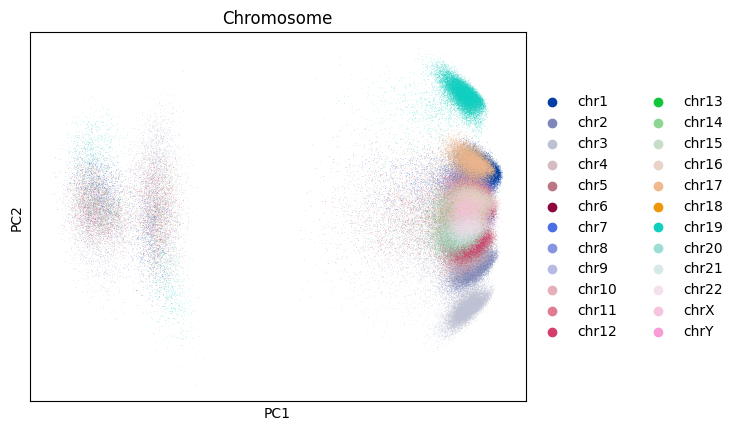

In [24]:
sc.pl.pca(adata_emb, color=["Chromosome"], ncols=1)

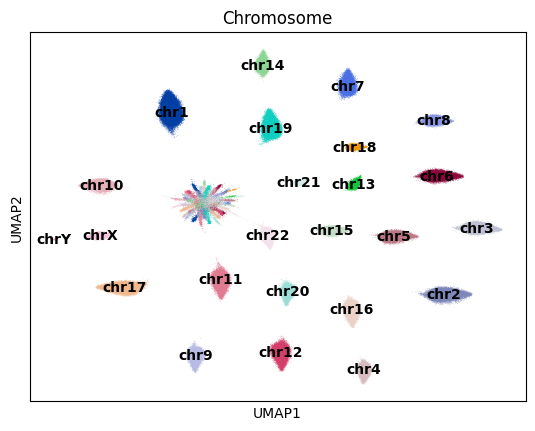

In [25]:
sc.pl.umap(
    adata_emb,
    color=["Chromosome"],
    ncols=1,
    legend_loc="on data"
)